In [35]:
# 14.01.2025: code works, but I have to invert the sense of the distance
# since waves are travelling backwards now

# and then consequently I will have to change: 
# #start_time = 0  # Time in seconds starts at 0
#start_distance = cumulative_distances[-1]
#propagation_line_distance = start_distance + propagation_speed * time_seconds  # Distance = speed * time


# Data source from the model: /DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_BLUELINK

# Kind of data : filtered_sla_lat_-25.35_lon_157.95.nc

# Type of content: 

In [36]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from scipy.spatial import cKDTree
import cartopy.feature as cfeature
import os
import re
from geopy.distance import geodesic  # Import geodesic for distance calculation
from scipy.signal import find_peaks

# Step 1: Define the parallelogram
parallelogram_vertices = np.array([
    [149, -38],  # Bottom-left
    [158, -38],  # Bottom-right
    [158, -25],  # Top-right
    [149, -25]   # Top-left
])
parallelogram = Polygon(parallelogram_vertices)

# Step 2: Extract coastline using Cartopy
coastline = list(cfeature.COASTLINE.geometries())
coastline_points = []

for geometry in coastline:
    if geometry.intersects(parallelogram):
        if geometry.geom_type == 'LineString':
            coastline_points.extend(np.array(geometry.coords))
        elif geometry.geom_type == 'MultiLineString':
            for line in geometry:
                coastline_points.extend(np.array(line.coords))

coastline_points = np.array(coastline_points)

# Filter coastline points within the parallelogram
filtered_points = np.array([point for point in coastline_points if parallelogram.contains(Point(point))])

# Step 3: Interpolate Equally Spaced Points
coastline_line = LineString(filtered_points)
n_points = 20  # Define the number of equally spaced points
distances = np.linspace(0, coastline_line.length, n_points)
interpolated_points = np.array([coastline_line.interpolate(d).coords[0] for d in distances])

# Step 4: Compute Cumulative Distance
def compute_cumulative_distance(points):
    """Compute cumulative distances from the first point."""
    cumulative_distances = [0]  # Distance from the first point to itself is 0
    for i in range(1, len(points)):
        # Swap the order of coordinates (latitude, longitude)
        dist = geodesic((points[i-1][1], points[i-1][0]), (points[i][1], points[i][0])).meters
        cumulative_distances.append(cumulative_distances[-1] + dist)
    return np.array(cumulative_distances)

# Calculate cumulative distances
cumulative_distances = compute_cumulative_distance(interpolated_points)

# Step 5: Find Closest Grid Points
# Extract grid point coordinates from filenames
grid_data_dir = "/DGFI8/H/work_marcello/coastal_trapped_waves_data/filtered_grids_BLUELINK"
grid_points = []
files = os.listdir(grid_data_dir)

for file in files:
    match = re.search(r"lat_(-?\d+\.\d+)_lon_(-?\d+\.\d+)", file)
    if match:
        lat, lon = map(float, match.groups())
        grid_points.append((lon, lat))

grid_points = np.array(grid_points)

# Use cKDTree for efficient nearest-neighbor search
tree = cKDTree(grid_points)
distances, indices = tree.query(interpolated_points)
closest_points = grid_points[indices]

# Step 6: Extract Time Series
time_series_list = []

for i, index in enumerate(indices):
    file_name = f"filtered_sla_lat_{grid_points[index][1]}_lon_{grid_points[index][0]}.nc"
    file_path = os.path.join(grid_data_dir, file_name)

    # Open the NetCDF file and extract time series
    ds = xr.open_dataset(file_path)
    time_series = ds['filtered_sla'].values  # Assuming 'sla' is the variable name
    time_series_list.append(time_series)

time_series_matrix = np.array(time_series_list)

# Step 7: Create Hovmöller Diagram with Distance on the X-Axis
time = ds['time'].values  # Assuming 'time' is the time coordinate

Text(0.5, 1.0, 'Hovmöller Diagram of Sea Level Anomaly')

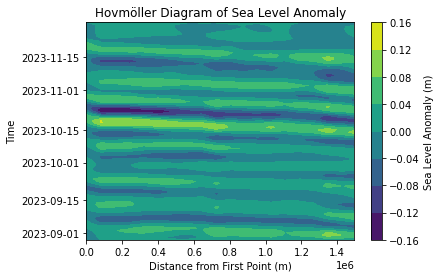

In [37]:

# Create the Hovmöller diagram using contourf
plt.contourf(cumulative_distances, time, time_series_matrix.T, cmap='viridis')
plt.colorbar(label='Sea Level Anomaly (m)')
plt.xlabel('Distance from First Point (m)')
plt.ylabel('Time')
plt.title('Hovmöller Diagram of Sea Level Anomaly')



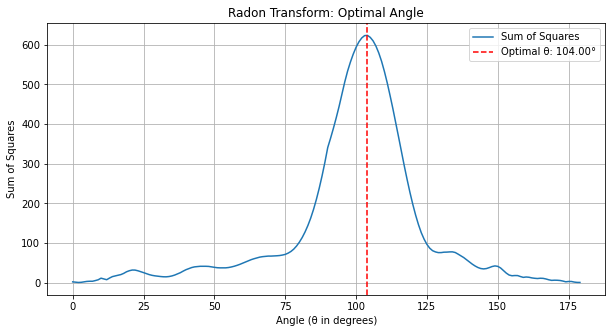

Optimal angle (θ): 104.00 degrees
tan(θ): -4.0108 s/m
Propagation speed: -0.2493 m/s


In [38]:
# Computation of the phase speed as according to the first method (Radon transform) explained by 
#  De-Leon, Y. and Paldor, N.: 
# Trapped planetary (Rossby) waves observed in the Indian Ocean by satellite borne altimeters, 
# Ocean Sci., 13, 483–494, https://doi.org/10.5194/os-13-483-2017, 2017. 

import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon

# Assuming `time_series_matrix` is your Hovmöller data (SSHA values)
# Rows correspond to time and columns to longitude (or distance)

# Step 1: Normalize and preprocess the data
data = time_series_matrix.T  # Transpose to match (longitude, time)
data_min = np.min(data)
data_max = np.max(data)
data_scaled = (data - data_min) / (data_max - data_min)  # Scale to [0, 1]
data_scaled -= np.mean(data_scaled)  # Subtract the mean

# Step 2: Apply the Radon transform
# Radon transform requires a 2D array and computes projections for specified angles
theta = np.linspace(0, 180, 180, endpoint=False)  # Angles in degrees
radon_transform = radon(data_scaled, theta=theta, circle=False)

# Step 3: Compute the sum of squares for each angle
sum_of_squares = np.sum(radon_transform**2, axis=0)

# Find the angle θ with the maximum sum of squares
optimal_theta = theta[np.argmax(sum_of_squares)]

# Step 4: Calculate the propagation speed
# tan(θ) gives the slope in seconds per meter
tan_theta = np.tan(np.deg2rad(optimal_theta))

# Speed in meters per second (inverse of the slope)
if tan_theta != 0:  # Avoid division by zero
    propagation_speed = 1 / tan_theta
else:
    propagation_speed = np.inf  # Infinite speed if tan_theta is 0 (flat line)

# Plot the Radon transform result
plt.figure(figsize=(10, 5))
plt.plot(theta, sum_of_squares, label='Sum of Squares')
plt.axvline(optimal_theta, color='r', linestyle='--', label=f'Optimal θ: {optimal_theta:.2f}°')
plt.xlabel('Angle (θ in degrees)')
plt.ylabel('Sum of Squares')
plt.title('Radon Transform: Optimal Angle')
plt.legend()
plt.grid()
plt.show()

# Output the results
print(f"Optimal angle (θ): {optimal_theta:.2f} degrees")
print(f"tan(θ): {tan_theta:.4f} s/m")
print(f"Propagation speed: {propagation_speed:.4f} m/s")


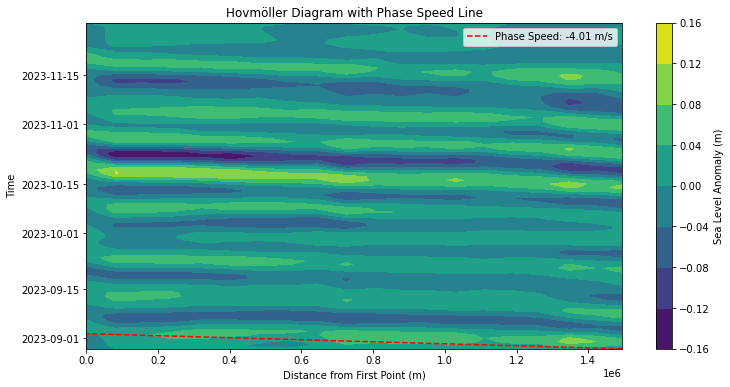

Optimal angle (θ): 166.00 degrees
tan(θ): -0.2493 s/m
Propagation speed: -4.0108 m/s


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon

# Assuming `time_series_matrix`, `time`, and `cumulative_distances` are already loaded

# Step 1: Normalize and preprocess the data
data = time_series_matrix  # Transpose to match (distance, time)
data_min = np.min(data)
data_max = np.max(data)
data_scaled = (data - data_min) / (data_max - data_min)  # Scale to [0, 1]
data_scaled -= np.mean(data_scaled)  # Subtract the mean

# Step 2: Apply the Radon transform
theta = np.linspace(0, 180, 180, endpoint=False)  # Angles in degrees
radon_transform = radon(data_scaled, theta=theta, circle=False)

# Step 3: Compute the sum of squares for each angle
sum_of_squares = np.sum(radon_transform**2, axis=0)

# Find the angle θ with the maximum sum of squares
optimal_theta = theta[np.argmax(sum_of_squares)]

# Step 4: Calculate the propagation speed
tan_theta = np.tan(np.deg2rad(optimal_theta))  # Slope in seconds per meter
if tan_theta != 0:
    propagation_speed = 1 / tan_theta  # Speed in meters per second
else:
    propagation_speed = np.inf

# Step 5: Convert time to seconds for arithmetic operations
time_seconds = (time - time[0]) / np.timedelta64(1, 's')  # Convert to seconds

# Step 6: Plot the Hovmöller diagram
plt.figure(figsize=(12, 6))
plt.contourf(cumulative_distances, time, time_series_matrix.T, cmap='viridis')
plt.colorbar(label='Sea Level Anomaly (m)')
plt.xlabel('Distance from First Point (m)')
plt.ylabel('Time')
plt.title('Hovmöller Diagram with Phase Speed Line')

# Step 7: Overlay the straight line corresponding to the phase speed
# Calculate the propagation line
#start_time = 0  # Time in seconds starts at 0
start_distance = cumulative_distances[-1]
propagation_line_distance = start_distance + propagation_speed * time_seconds  # Distance = speed * time

# Plot the propagation line
plt.plot(propagation_line_distance, time, color='red', linestyle='--', label=f'Phase Speed: {propagation_speed:.2f} m/s')

# Ensure only positive values on the x-axis
plt.xlim(left=0)  # Set the minimum x-axis limit to 0

# Add a legend
plt.legend()
plt.show()

# Step 8: Output the results
print(f"Optimal angle (θ): {optimal_theta:.2f} degrees")
print(f"tan(θ): {tan_theta:.4f} s/m")
print(f"Propagation speed: {propagation_speed:.4f} m/s")


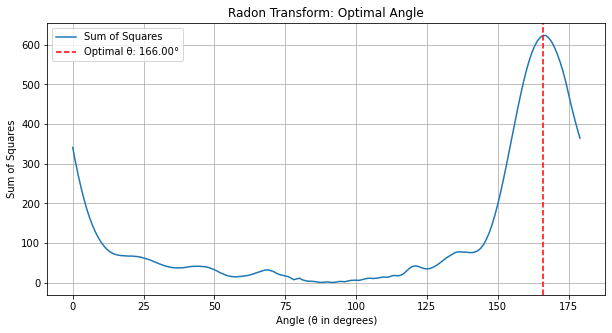

In [40]:
# Plot the Radon transform result
plt.figure(figsize=(10, 5))
plt.plot(theta, sum_of_squares, label='Sum of Squares')
plt.axvline(optimal_theta, color='r', linestyle='--', label=f'Optimal θ: {optimal_theta:.2f}°')
plt.xlabel('Angle (θ in degrees)')
plt.ylabel('Sum of Squares')
plt.title('Radon Transform: Optimal Angle')
plt.legend()
plt.grid()
plt.show()

